Цилих А.
Карлышев А.
>М19-ИВТ-3

6 - 2

https://www.tensorflow.org/datasets/catalog/deep_weeds

https://keras.io/api/applications/vgg/#vgg16-function

Часть 1

* Изучение сети и набора данных
* Выполнить анализ статьи
* Разобрать структуру сети
* Принести распечатанную статью
* подготовить презентацию по структуре сети и набору данных
* написать код по загрузке набора данных в Google Colab 
* визуализации части изображений из набора данных
* используйте генератор для передачи данных в нейронную сеть

часть 2 Программная реализация структуры сети. 

* определить структурный элемент сети
* Построить несколько вариантов сетей с разным числом структурных элементов
* Для загрузки данных использовать генератор
* Зашумить изображения для теста
* оценить точность
* Визуализировать карту признаков
* Визуализировать ядра свёртки для разных слоёв одного вариантов из обученных сетей
* Должна быть выбрана архитекутра сети, обеспечивающая наилучшую точность распознавания



* По результатам должна быть оформлена презентация.



In [1]:
import keras
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, BatchNormalization, Dropout
import pandas as pd
import numpy as np
import os
import random
import numpy as np
from matplotlib.pyplot import imshow
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
from google.colab import drive

In [2]:
# ------------------------------------------------------------ визуализация и т.д. ------------------------------------------------------------
#загрузка с диска
#монтируем диск
drive.mount('/content/gdrive', force_remount=True)
#проверям
!df -h
!ls /content/gdrive/"My Drive"/"лабораторная 2"

Mounted at /content/gdrive
Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   37G  48% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   16K  6.4G   1% /var/colab
/dev/sda1        75G   34G   42G  45% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  975M   15G   7% /content/gdrive
images.zip  labels.csv


In [3]:
#копируем с диска
!cp /content/gdrive/'My Drive'/"лабораторная 2"/labels.csv .
!cp /content/gdrive/'My Drive'/"лабораторная 2"/images.zip .
!unzip -uq "images.zip" -d "/content/uzi/"
!ls
!mkdir  train
!mkdir  train/cl0
!mkdir  train/cl1
!mkdir  train/cl2
!mkdir  train/cl3
!mkdir  train/cl4
!mkdir  train/cl5
!mkdir  train/cl6
!mkdir  train/cl7
!mkdir  train/cl8

!mkdir  test
!mkdir  test/cl0
!mkdir  test/cl1
!mkdir  test/cl2
!mkdir  test/cl3
!mkdir  test/cl4
!mkdir  test/cl5
!mkdir  test/cl6
!mkdir  test/cl7
!mkdir  test/cl8

!mkdir  val
!mkdir  val/cl0
!mkdir  val/cl1
!mkdir  val/cl2
!mkdir  val/cl3
!mkdir  val/cl4
!mkdir  val/cl5
!mkdir  val/cl6
!mkdir  val/cl7
!mkdir  val/cl8

gdrive	images.zip  labels.csv	sample_data  uzi


In [4]:
#читаем в переменную
labels = pd.read_csv('labels.csv').drop(['Filename','Species'], axis='columns')
names = pd.read_csv('labels.csv')#.drop(['Label','Species'], axis='columns')
print(names)
# получить имена классов для разделения по папкам
class1 = (names[names['Label'] == 0]).drop(['Species', 'Label'], axis='columns').to_numpy()
class2 = (names[names['Label'] == 1]).drop(['Species', 'Label'], axis='columns').to_numpy()
class3 = (names[names['Label'] == 2]).drop(['Species', 'Label'], axis='columns').to_numpy()
class4 = (names[names['Label'] == 3]).drop(['Species', 'Label'], axis='columns').to_numpy()
class5 = (names[names['Label'] == 4]).drop(['Species', 'Label'], axis='columns').to_numpy()
class6 = (names[names['Label'] == 5]).drop(['Species', 'Label'], axis='columns').to_numpy()
class7 = (names[names['Label'] == 6]).drop(['Species', 'Label'], axis='columns').to_numpy()
class8 = (names[names['Label'] == 7]).drop(['Species', 'Label'], axis='columns').to_numpy()
class9 = (names[names['Label'] == 8]).drop(['Species', 'Label'], axis='columns').to_numpy()

                    Filename  Label       Species
0      20160928-140314-0.jpg      0  Chinee apple
1      20160928-140337-0.jpg      0  Chinee apple
2      20160928-140731-0.jpg      0  Chinee apple
3      20160928-140747-0.jpg      0  Chinee apple
4      20160928-141107-0.jpg      0  Chinee apple
...                      ...    ...           ...
17504  20180322-133822-1.jpg      8      Negative
17505  20180322-133832-1.jpg      8      Negative
17506  20180322-133840-1.jpg      8      Negative
17507  20180322-133850-1.jpg      8      Negative
17508  20180322-133901-1.jpg      8      Negative

[17509 rows x 3 columns]


In [5]:
# положить процент фоток в директорию
p1 = 70
p2 = 20
p3 = 10

nb_train_samples = 0
nb_validation_samples = 0
nb_test_samples = 0

kol1 = round(len(class1)*p1/100)
kol2 = round(len(class1)*p2/100)
# kol3 = len(class1) - kol1 - kol2

nb_train_samples = nb_train_samples + kol1
nb_validation_samples = nb_validation_samples + kol2
# nb_test_samples = nb_test_samples + kol3
nb_test_samples = nb_test_samples + (len(class1) - kol1 - kol2)

i = 0
while i < len(class1):
    if (i<kol1):
      t = "cp uzi/" + str(class1[i][0]) + " train/cl0"
      os.system(t)
    if (i < kol1 + kol2):
      t = "cp uzi/" + str(class1[i][0]) + " test/cl0"
      os.system(t)
    # if (i > kol3):
    if (i > kol1 + kol2):
      t = "cp uzi/" + str(class1[i][0]) + " val/cl0"
      os.system(t)
    i = i + 1
print("ok 1")

kol1 = round(len(class2)*p1/100)
kol2 = round(len(class2)*p2/100)
# kol3 = len(class2) - kol1 - kol2

nb_train_samples = nb_train_samples + kol1
nb_validation_samples = nb_validation_samples + kol2
# nb_test_samples = nb_test_samples + kol3
nb_test_samples = nb_test_samples + (len(class2) - kol1 - kol2)

i = 0
while i < len(class2):
    if (i<kol1):
      t = "cp uzi/" + str(class2[i][0]) + " train/cl1"
      os.system(t)
    if (i < kol1 + kol2):
    # if (i > kol1 and i < kol2):
      t = "cp uzi/" + str(class2[i][0]) + " test/cl1"
      os.system(t)
    if (i > kol1 + kol2):
    # if (i > kol3):
      t = "cp uzi/" + str(class2[i][0]) + " val/cl1"
      os.system(t)
    i = i + 1
print("ok 2")

kol1 = round(len(class3)*p1/100)
kol2 = round(len(class3)*p2/100)
# kol3 = len(class3) - kol1 - kol2

nb_train_samples = nb_train_samples + kol1
nb_validation_samples = nb_validation_samples + kol2
# nb_test_samples = nb_test_samples + kol3
nb_test_samples = nb_test_samples + (len(class3) - kol1 - kol2)

i = 0
while i < len(class3):
    if (i<kol1):
      t = "cp uzi/" + str(class3[i][0]) + " train/cl2"
      os.system(t)
    if (i < kol1 + kol2):
    # if (i > kol1 and i < kol2):
      t = "cp uzi/" + str(class3[i][0]) + " test/cl2"
      os.system(t)
    if (i > kol1 + kol2):
    # if (i > kol3):
      t = "cp uzi/" + str(class3[i][0]) + " val/cl2"
      os.system(t)
    i = i + 1
print("ok 3")

kol1 = round(len(class4)*p1/100)
kol2 = round(len(class4)*p2/100)
# kol3 = len(class4) - kol1 - kol2

nb_train_samples = nb_train_samples + kol1
nb_validation_samples = nb_validation_samples + kol2
# nb_test_samples = nb_test_samples + kol3
nb_test_samples = nb_test_samples + (len(class4) - kol1 - kol2)

i = 0
while i < len(class4):
    if (i<kol1):
      t = "cp uzi/" + str(class4[i][0]) + " train/cl3"
      os.system(t)
    if (i < kol1 + kol2):
    # if (i > kol1 and i < kol2):
      t = "cp uzi/" + str(class4[i][0]) + " test/cl3"
      os.system(t)
    if (i > kol1 + kol2):
    # if (i > kol3):
      t = "cp uzi/" + str(class4[i][0]) + " val/cl3"
      os.system(t)
    i = i + 1
print("ok 4")

kol1 = round(len(class5)*p1/100)
kol2 = round(len(class5)*p2/100)
# kol3 = len(class5) - kol1 - kol2

nb_train_samples = nb_train_samples + kol1
nb_validation_samples = nb_validation_samples + kol2
# nb_test_samples = nb_test_samples + kol3
nb_test_samples = nb_test_samples + (len(class5) - kol1 - kol2)

i = 0
while i < len(class5):
    if (i<kol1):
      t = "cp uzi/" + str(class5[i][0]) + " train/cl4"
      os.system(t)
    if (i < kol1 + kol2):
    # if (i > kol1 and i < kol2):
      t = "cp uzi/" + str(class5[i][0]) + " test/cl4"
      os.system(t)
    if (i > kol1 + kol2):
    # if (i > kol3):
      t = "cp uzi/" + str(class5[i][0]) + " val/cl4"
      os.system(t)
    i = i + 1
print("ok 5")

kol1 = round(len(class6)*p1/100)
kol2 = round(len(class6)*p2/100)
# kol3 = len(class6) - kol1 - kol2

nb_train_samples = nb_train_samples + kol1
nb_validation_samples = nb_validation_samples + kol2
# nb_test_samples = nb_test_samples + kol3
nb_test_samples = nb_test_samples + (len(class6) - kol1 - kol2)

i = 0
while i < len(class6):
    if (i<kol1):
      t = "cp uzi/" + str(class6[i][0]) + " train/cl5"
      os.system(t)
    if (i < kol1 + kol2):
    # if (i > kol1 and i < kol2):
      t = "cp uzi/" + str(class6[i][0]) + " test/cl5"
      os.system(t)
    if (i > kol1 + kol2):  
    # if (i > kol3):
      t = "cp uzi/" + str(class6[i][0]) + " val/cl5"
      os.system(t)
    i = i + 1
print("ok 6")

kol1 = round(len(class7)*p1/100)
kol2 = round(len(class7)*p2/100)
# kol3 = len(class7) - kol1 - kol2

nb_train_samples = nb_train_samples + kol1
nb_validation_samples = nb_validation_samples + kol2
# nb_test_samples = nb_test_samples + kol3
nb_test_samples = nb_test_samples + (len(class7) - kol1 - kol2)

i = 0
while i < len(class7):
    if (i<kol1):
      t = "cp uzi/" + str(class7[i][0]) + " train/cl6"
      os.system(t)
    if (i < kol1 + kol2):
    # if (i > kol1 and i < kol2):
      t = "cp uzi/" + str(class7[i][0]) + " test/cl6"
      os.system(t)
    if (i > kol1 + kol2):
    # if (i > kol3):
      t = "cp uzi/" + str(class7[i][0]) + " val/cl6"
      os.system(t)
    i = i + 1
print("ok 7")

kol1 = round(len(class8)*p1/100)
kol2 = round(len(class8)*p2/100)
# kol3 = len(class8) - kol1 - kol2

nb_train_samples = nb_train_samples + kol1
nb_validation_samples = nb_validation_samples + kol2
# nb_test_samples = nb_test_samples + kol3
nb_test_samples = nb_test_samples + (len(class8) - kol1 - kol2)

i = 0
while i < len(class8):
    if (i<kol1):
      t = "cp uzi/" + str(class8[i][0]) + " train/cl7"
      os.system(t)
    if (i < kol1 + kol2):
    # if (i > kol1 and i < kol2):
      t = "cp uzi/" + str(class8[i][0]) + " test/cl7"
      os.system(t)
    if (i > kol1 + kol2):
    # if (i > kol3):
      t = "cp uzi/" + str(class8[i][0]) + " val/cl7"
      os.system(t)
    i = i + 1
print("ok 8")

kol1 = round(len(class9)*p1/100)
kol2 = round(len(class9)*p2/100)
# kol3 = len(class9) - kol1 - kol2

nb_train_samples = nb_train_samples + kol1
nb_validation_samples = nb_validation_samples + kol2
# nb_test_samples = nb_test_samples + kol3
nb_test_samples = nb_test_samples + (len(class9) - kol1 - kol2)

i = 0
while i < len(class9):
    if (i<kol1):
      t = "cp uzi/" + str(class9[i][0]) + " train/cl8"
      os.system(t)
    if (i < kol1 + kol2):
    # if (i > kol1 and i < kol2):
      t = "cp uzi/" + str(class9[i][0]) + " test/cl8"
      os.system(t)
    if (i > kol1 + kol2):
    # if (i > kol3):
      t = "cp uzi/" + str(class9[i][0]) + " val/cl8"
      os.system(t)
    i = i + 1
print("ok 9")

ok 1
ok 2
ok 3
ok 4
ok 5
ok 6
ok 7
ok 8
ok 9


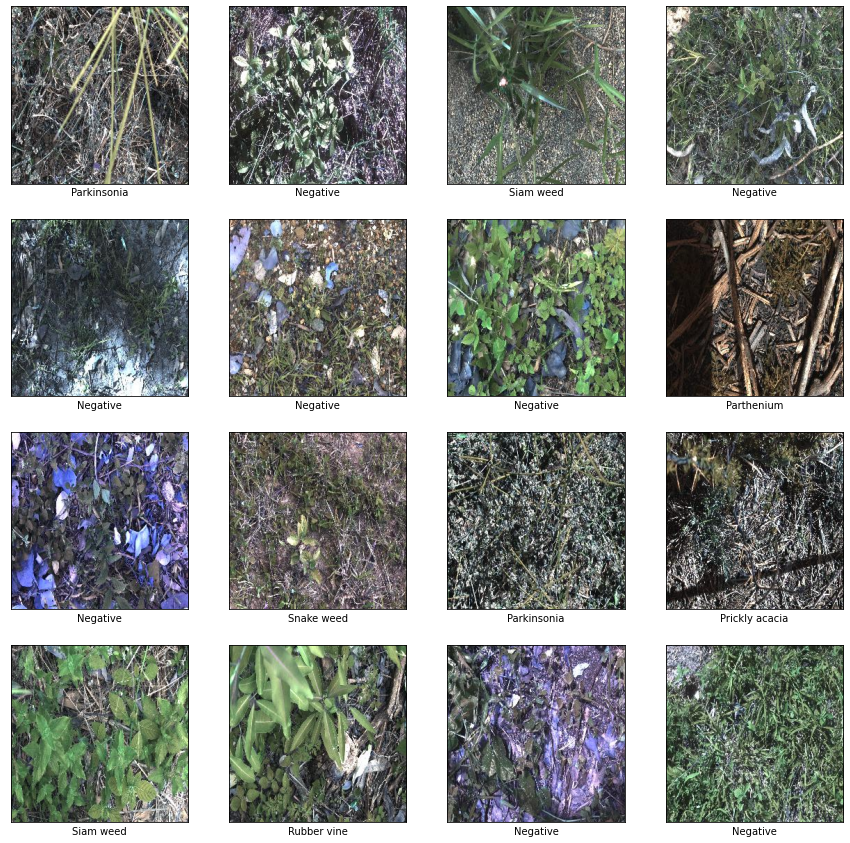

(256, 256, 3)


In [6]:
# визуализация классов изображений
test = list(range(0, 17508))
random.shuffle(test)
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.imread("uzi/" + names['Filename'][test[i]]))
    plt.xlabel(names['Species'][test[i]])
plt.show()
image = cv2.imread("uzi/" + names['Filename'][test[0]])
print(image.shape)

In [8]:
# ------------------------------------------------------------ обычная сеть ------------------------------------------------------------
vgg16_net = VGG16(include_top=False,input_shape=(256,256,3))
vgg16_net.trainable=True

58892288/58889256 [==============================] - 0s 0us/step


In [9]:
def build_model(classes):
  model = Sequential()
  model.add(vgg16_net)
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(classes))
  model.add(Activation("softmax"))  
  return model

In [10]:
# инициализируем нашу VGG-подобную сверточную нейросеть
model = build_model(9)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4

In [11]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [12]:
batch_size = 30

train_dir = "train"
val_dir = "val"
test_dir = "test"
datagen = ImageDataGenerator(rescale=1. /255)

In [13]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 12256 images belonging to 9 classes.


In [14]:
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1743 images belonging to 9 classes.


In [15]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15757 images belonging to 9 classes.


In [16]:
# ----------------------------------------------
h = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs = 15,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
408/408 [==============================] - 108s 266ms/step - loss: 1.7413 - accuracy: 0.4593 - val_loss: 2.9005 - val_accuracy: 0.5209
Epoch 2/15
408/408 [==============================] - 102s 250ms/step - loss: 1.4996 - accuracy: 0.5196
Epoch 3/15
408/408 [==============================] - 102s 251ms/step - loss: 1.3207 - accuracy: 0.5408
Epoch 4/15
408/408 [==============================] - 102s 251ms/step - loss: 1.2137 - accuracy: 0.5661
Epoch 5/15
408/408 [==============================] - 102s 250ms/step - loss: 1.1582 - accuracy: 0.5824
Epoch 6/15
408/408 [==============================] - 102s 251ms/step - loss: 1.1191 - accuracy: 0.5967
Epoch 7/15
408/408 [==============================] - 102s 250ms/step - loss: 1.0771 - accuracy: 0.6085
Epoch 8/15
408/408 [==============================] - 102s 250ms/step - loss: 1.0392 - accuracy: 0.6251
Epoch 9/15
408/408 [==============================

In [17]:
# сохраним сеть
model_json = model.to_json()
json_file = open("ts1.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights("ts1.h5")
print("ok")

ok


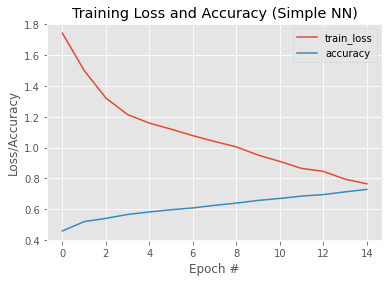

In [18]:
import matplotlib.pyplot as plt
# строим графики потерь и точности
N = np.arange(0, 15)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, h.history["loss"], label="train_loss")
# plt.plot(N, h.history["val_loss"], label="val_loss")
plt.plot(N, h.history["accuracy"], label="accuracy")
# plt.plot(N, h.history["val_mae"], label="val_mae")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("plot.jpg")
plt.show()

In [19]:
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Актуальность на тесте: %.2f%%" % (scores[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.
Актуальность на тесте: 64.94%


In [20]:
from google.colab import files
files.download("ts1.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
files.download("ts1.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# ------------------------------------------------------------ сеть VGG16 без нескольких структурнрых элементов ------------------------------------------------------------

In [7]:
# создание сети
batch_size = 30

train_dir = "train"
val_dir = "val"
test_dir = "test"
datagen = ImageDataGenerator(rescale=1. /255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 12256 images belonging to 9 classes.
Found 1743 images belonging to 9 classes.
Found 15757 images belonging to 9 classes.


In [8]:
# от обычной 
# Обрезка, как в лучших синагогах
model = Sequential()
model.add(Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4096,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=9, activation="softmax"))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)       2

In [10]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [11]:
h = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs = 15,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
408/408 [==============================] - 123s 301ms/step - loss: 2.6561 - accuracy: 0.3819 - val_loss: 3.1978 - val_accuracy: 0.5100
Epoch 2/15
408/408 [==============================] - 116s 285ms/step - loss: 2.3091 - accuracy: 0.4240
Epoch 3/15
408/408 [==============================] - 116s 285ms/step - loss: 2.2225 - accuracy: 0.4358
Epoch 4/15
408/408 [==============================] - 116s 285ms/step - loss: 2.1303 - accuracy: 0.4468
Epoch 5/15
408/408 [==============================] - 116s 285ms/step - loss: 2.1096 - accuracy: 0.4509
Epoch 6/15
408/408 [==============================] - 116s 285ms/step - loss: 2.0265 - accuracy: 0.4582
Epoch 7/15
408/408 [==============================] - 117s 286ms/step - loss: 1.9234 - accuracy: 0.4616
Epoch 8/15
408/408 [==============================] - 116s 285ms/step - loss: 1.8543 - accuracy: 0.4749
Epoch 9/15
408/408 [==============================

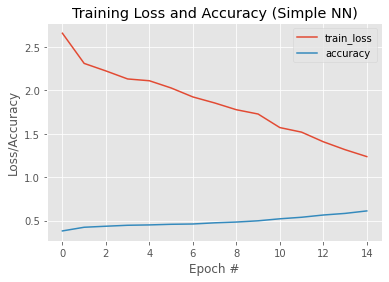

In [12]:
import matplotlib.pyplot as plt
# строим графики потерь и точности
N = np.arange(0, 15)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, h.history["loss"], label="train_loss")
# plt.plot(N, h.history["val_loss"], label="val_loss")
plt.plot(N, h.history["accuracy"], label="accuracy")
# plt.plot(N, h.history["val_mae"], label="val_mae")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("plot.jpg")
plt.show()

In [ ]:
# ------------------------------------------------------------ сеть VGG16 плюс нескольких структурнрых элементов ------------------------------------------------------------

In [13]:
# от обычной + 1 элемент
model = Sequential()
model.add(Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4096,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=9, activation="softmax"))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 256)      

In [15]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [16]:
h = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs = 15,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/15
408/408 [==============================] - 112s 274ms/step - loss: 2.6069 - accuracy: 0.3857 - val_loss: 30.5908 - val_accuracy: 0.0591
Epoch 2/15
408/408 [==============================] - 106s 261ms/step - loss: 2.3817 - accuracy: 0.4095
Epoch 3/15
408/408 [==============================] - 106s 260ms/step - loss: 2.2555 - accuracy: 0.4142
Epoch 4/15
408/408 [==============================] - 107s 261ms/step - loss: 2.1963 - accuracy: 0.4256
Epoch 5/15
408/408 [==============================] - 106s 261ms/step - loss: 2.1265 - accuracy: 0.4255
Epoch 6/15
408/408 [==============================] - 107s 261ms/step - loss: 2.0773 - accuracy: 0.4296
Epoch 7/15
408/408 [==============================] - 106s 261ms/step - loss: 2.0372 - accuracy: 0.4270
Epoch 8/15
408/408 [==============================] - 107s 261ms/step - loss: 1.9921 - accuracy: 0.4378
Epoch 9/15
408/408 [==============================] - 107s 261ms/step - loss: 1.8670 - accuracy: 0.4521
Epoch 10/15
408/408 [

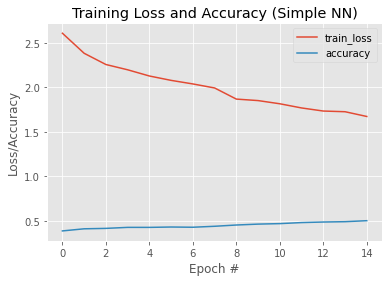

In [17]:
import matplotlib.pyplot as plt
# строим графики потерь и точности
N = np.arange(0, 15)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, h.history["loss"], label="train_loss")
# plt.plot(N, h.history["val_loss"], label="val_loss")
plt.plot(N, h.history["accuracy"], label="accuracy")
# plt.plot(N, h.history["val_mae"], label="val_mae")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("plot.jpg")
plt.show()

In [ ]:
# ------------------------------------------------------------ сеть VGG16 обычная сеть плюс шум ------------------------------------------------------------

In [22]:
S = 1
def get_normal_noise(image):
 noise = np.random.normal(128, 20, (image.shape[0], image.shape[1]))
 return np.dstack((noise, noise, noise)).astype(np.uint8)
def add_normal_noise(image):
 noise = get_normal_noise(image) * S
 noise_image = cv2.add(image.astype(np.float64), noise.astype(np.float64))
 cv2.normalize(noise_image, noise_image, 0, 255, cv2.NORM_MINMAX)
 return noise_image
def get_uniform_noise(image):
 noise = np.random.uniform(0, 255, (image.shape[0], image.shape[1]))
 return np.dstack((noise, noise, noise)).astype(np.uint8)
def add_uniform_noise(image):
 noise = get_uniform_noise(image) * S
 noise_image = cv2.add(image.astype(np.float64), noise.astype(np.float64))
 cv2.normalize(noise_image, noise_image, 0, 255, cv2.NORM_MINMAX)
 return noise_image

In [27]:
vgg16_net = VGG16(include_top=False,input_shape=(256,256,3))
vgg16_net.trainable=True

def build_model(classes):
  model = Sequential()
  model.add(vgg16_net)
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(classes))
  model.add(Activation("softmax"))  
  return model

# инициализируем нашу VGG-подобную сверточную нейросеть
model = build_model(9)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               16777728  
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 9)                

In [28]:
# model = Sequential()
# model.add(Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Flatten())
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units=9, activation="softmax"))
# model.summary()
# model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [29]:
# def preprocessor(image):
#   row,col,ch= image.shape
#   mean = 0
#   var = 0.1
#   sigma = var**0.5
#   gauss = np.random.normal(mean,sigma,(row,col,ch))
#   gauss = gauss.reshape(row,col,ch)
#   noisy = image + gauss  
#   return (noisy)

In [30]:
batch_size = 30

train_dir = "train"
val_dir = "val"
test_dir = "test"
# datagen = ImageDataGenerator(rescale=1. /255, preprocessing_function=preprocessor)
datagen = ImageDataGenerator(rescale=1. /255)

In [31]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 12256 images belonging to 9 classes.


In [32]:
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1743 images belonging to 9 classes.


In [33]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 15757 images belonging to 9 classes.


In [34]:
h = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs = 15,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/15
408/408 [==============================] - 107s 263ms/step - loss: 1.7174 - accuracy: 0.4650 - val_loss: 2.6700 - val_accuracy: 0.0476
Epoch 2/15
408/408 [==============================] - 102s 251ms/step - loss: 1.4971 - accuracy: 0.5159
Epoch 3/15
408/408 [==============================] - 102s 250ms/step - loss: 1.3688 - accuracy: 0.5364
Epoch 4/15
408/408 [==============================] - 102s 250ms/step - loss: 1.3147 - accuracy: 0.5475
Epoch 5/15
408/408 [==============================] - 102s 250ms/step - loss: 1.2572 - accuracy: 0.5614
Epoch 6/15
408/408 [==============================] - 102s 251ms/step - loss: 1.1696 - accuracy: 0.5794
Epoch 7/15
408/408 [==============================] - 102s 250ms/step - loss: 1.1111 - accuracy: 0.5959
Epoch 8/15
408/408 [==============================] - 102s 250ms/step - loss: 1.0562 - accuracy: 0.6142
Epoch 9/15
408/408 [==============================] - 102s 250ms/step - loss: 1.0042 - accuracy: 0.6318
Epoch 10/15
408/408 [=

In [35]:
test_generator_with_normal_noise = ImageDataGenerator(rescale=1./255, preprocessing_function=add_normal_noise).flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=batch_size,
)

test_generator_with_uniform_noise = ImageDataGenerator(rescale=1./255, preprocessing_function=add_uniform_noise).flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=batch_size,
)

Found 15757 images belonging to 9 classes.
Found 15757 images belonging to 9 classes.


In [36]:
loss, accuracy = model.evaluate(test_generator_with_normal_noise)

526/526 [==============================] - 112s 213ms/step - loss: 6662.8711 - accuracy: 0.5551


In [37]:
loss, accuracy = model.evaluate(test_generator_with_uniform_noise)

526/526 [==============================] - 83s 157ms/step - loss: 150.0105 - accuracy: 0.4944


In [38]:
# ------------------------------------------------------------ визуализация признаков ------------------------------------------------------------

In [39]:
model = Sequential()
model.add(Conv2D(input_shape=(256,256,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4096,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=9, activation="softmax"))
model.summary()
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 256)      

In [40]:
batch_size = 30

train_dir = "train"
val_dir = "val"
test_dir = "test"
datagen = ImageDataGenerator(rescale=1. /255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image.shape[0],image.shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

h = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs = 15,
    validation_data=val_generator,
    validation_steps=nb_validation_samples // batch_size)

Found 12256 images belonging to 9 classes.
Found 1743 images belonging to 9 classes.
Found 15757 images belonging to 9 classes.
Epoch 1/15
408/408 [==============================] - 112s 275ms/step - loss: 2.7109 - accuracy: 0.3740 - val_loss: 7.5405 - val_accuracy: 0.4940
Epoch 2/15
408/408 [==============================] - 107s 262ms/step - loss: 2.3577 - accuracy: 0.4228
Epoch 3/15
408/408 [==============================] - 107s 262ms/step - loss: 2.3018 - accuracy: 0.4309
Epoch 4/15
408/408 [==============================] - 107s 262ms/step - loss: 2.2472 - accuracy: 0.4373
Epoch 5/15
408/408 [==============================] - 107s 263ms/step - loss: 2.1806 - accuracy: 0.4460
Epoch 6/15
408/408 [==============================] - 107s 262ms/step - loss: 2.1706 - accuracy: 0.4471
Epoch 7/15
408/408 [==============================] - 107s 262ms/step - loss: 2.1549 - accuracy: 0.4438
Epoch 8/15
408/408 [==============================] - 107s 262ms/step - loss: 2.0636 - accuracy: 0.449

In [42]:
# Номера сверточных слоев - 0, 1, 3, 4, 6...
activation_model = Model(inputs=model.input, outputs=model.layers[1].output)

In [43]:
activation_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26_input (InputLayer) [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 256, 256, 64)      36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


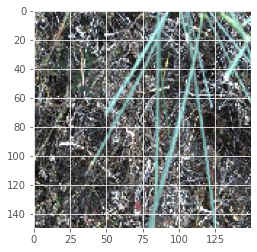

In [44]:
# ----------------------
# показ
from tensorflow.python.keras.preprocessing import image
image_file_name = "uzi/" + names['Filename'][test[0]]
img = image.load_img(image_file_name, target_size=(150, 150))
plt.imshow(img)

In [45]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.
print(img_array.shape)
activation = activation_model.predict(img_array)
print(activation.shape)

(1, 150, 150, 3)
(1, 150, 150, 64)


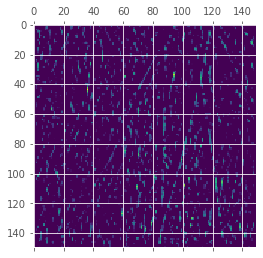

In [47]:
plt.matshow(activation[0, :, :, 10], cmap='viridis')
# показать 1 из шаблонов сети

In [48]:
images_per_row = 16
n_filters = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filters // images_per_row

In [49]:
display_grid = np.zeros((n_cols * size, images_per_row * size))

In [50]:
for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


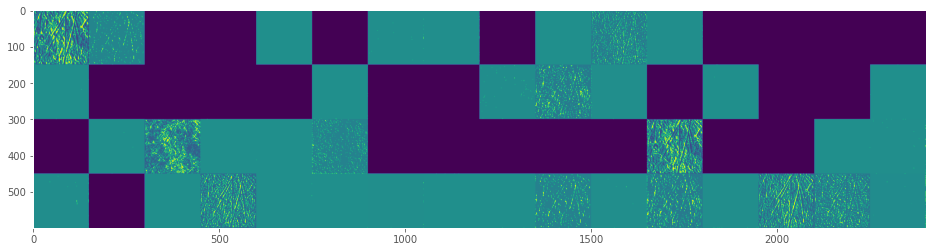

In [51]:
# Пригзнаки
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')